# Running Simulations of Complex Models

In our group, we use many agent-based models, sampling them with the Gillespie Algorithm. 

- Many independent memoryless events
- Discrete state space

In [309]:
from random import random
from math import log
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

## Example: Simple Birth-Death Process

In [393]:
# Gillespie Algorithm for a Simple Birth-Death Process
def run(initial_condition, duration, b, d):
    t = 0
    pop_count = initial_condition
    while True:
        birth_rate = pop_count * b
        death_rate = pop_count * d
        total_rate = birth_rate + death_rate
        if total_rate == 0:
            break

        # Sample time until next event
        waiting_time = - log(random()) / total_rate 
        
        # Update time
        t += waiting_time

        # If next event is too late, end loop before updating state
        if t > duration: 
            break

        # Sample whether event is birth or death and implement it
        event_index = random()
        if event_index < birth_rate / total_rate: 
            pop_count += 1
        else:
            pop_count -= 1

    return pop_count


initial_condition = 100
duration = 5
b = 1
d = 0.5

pop_count = run(initial_condition, duration, b, d)
print(f"Initial condition: {initial_condition} | Birthrate: {b} | Deathrate: {d}")
print(f"At time t={duration}, population size is {pop_count}")



Initial condition: 100 | Birthrate: 1 | Deathrate: 0.5
At time t=5, population size is 1379


### Generating Timepoint data

In [311]:
def sample_at_times(initial_condition, times, b, d):
    last_time = 0
    population_size = initial_condition
    result = []
    for timepoint in times:
        population_size = run(population_size, timepoint - last_time, b, d)
        result.append(population_size)
        last_time = timepoint
    return result


initial_condition = 100
timepoints = [i / 100 for i in range(1000)]
b = 1
d = 1

result = sample_at_times(initial_condition, timepoints, b, d)
print(result)

[100, 100, 98, 94, 93, 92, 92, 91, 89, 89, 90, 90, 88, 87, 87, 91, 92, 93, 91, 92, 92, 92, 92, 93, 93, 94, 93, 93, 95, 96, 97, 95, 97, 98, 101, 100, 100, 98, 99, 98, 98, 99, 97, 97, 96, 94, 95, 96, 96, 97, 99, 101, 102, 105, 106, 104, 105, 107, 107, 108, 109, 107, 108, 108, 109, 110, 108, 109, 110, 111, 111, 111, 110, 111, 111, 110, 111, 110, 110, 110, 107, 107, 106, 105, 105, 105, 105, 105, 105, 105, 108, 110, 112, 114, 113, 110, 110, 110, 111, 113, 113, 115, 114, 112, 114, 116, 116, 115, 116, 116, 115, 114, 117, 116, 116, 115, 116, 117, 118, 118, 118, 118, 117, 115, 116, 115, 116, 116, 118, 118, 119, 121, 119, 119, 119, 119, 118, 119, 120, 120, 122, 123, 124, 124, 124, 124, 123, 123, 122, 120, 121, 122, 122, 121, 123, 121, 124, 126, 123, 124, 123, 121, 120, 121, 120, 120, 117, 118, 114, 116, 115, 115, 115, 114, 114, 116, 117, 119, 121, 122, 124, 124, 124, 123, 122, 120, 119, 121, 122, 122, 121, 123, 124, 123, 124, 120, 120, 121, 121, 124, 124, 125, 124, 121, 121, 122, 119, 122, 123, 

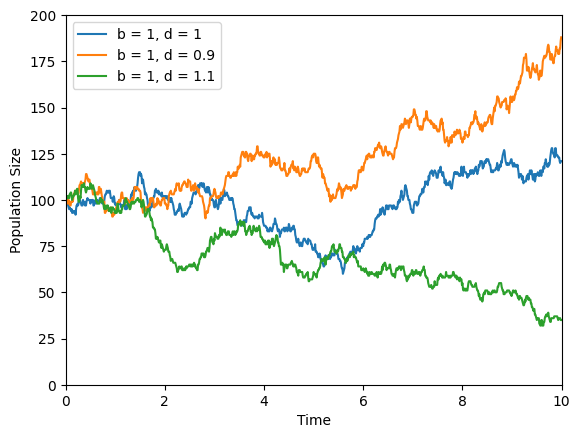

In [312]:
result = sample_at_times(initial_condition, timepoints, 1, 1)

result2 = sample_at_times(initial_condition, timepoints, 1, d - 0.1)

result3 = sample_at_times(initial_condition, timepoints, 1, d + 0.1)

fig, ax = plt.subplots()

ax.set_xlim(0, 10)
ax.set_ylim(0, 200)
ax.set_xlabel("Time")
ax.set_ylabel("Population Size")
ax.plot(timepoints, result, label = f"b = {b}, d = {d}")
ax.plot(timepoints, result2, label = f"b = {b}, d = {d - 0.1}")
ax.plot(timepoints, result3, label = f"b = {b}, d = {d + 0.1}")
ax.legend()
plt.show()


## Object Oriented Programming for Complex Agent-based Models


In [318]:
class Model:
    def __init__(self, events):
        self.events = events


    def run(self, initial_condition, duration, parameters):
        t = 0
        state = deepcopy(initial_condition)

        while True:
            # Calculate the rate of each event from current state
            event_rates = [event.get_rate(state, parameters) for event in self.events]
            total_rate = sum(event_rates)

            # If the total rate is 0, the current state is the final state
            if total_rate == 0:
                break

            # Sample the waiting time
            waiting_time = - log(random()) / total_rate

            # Update to the time of next event
            t += waiting_time

            # If the next event is after the end of the simulation, the current state is the final state
            if t > duration: 
                break

            # Sample which event occurs at time t
            event_index = random() * total_rate
            for event, event_rate in zip(self.events, event_rates):
                if event_index <= event_rate:
                    found_event = event
                    break
                event_index -= event_rate
            
            # Implement the event to determine the new state
            state = found_event.implement(state)
        
        return state

    def sample_at_times(self, initial_condition, times, parameters):
        last_time = 0
        state = deepcopy(initial_condition)
        result = []
        for time in times:
            state = self.run(state, time - last_time, parameters)
            result.append(state)
            last_time = time
        return result
            


class Event:
    def get_rate(self, state, parameters):
        pass

    def implement(self, state):
        pass
    
    


In [321]:

class SimpleBirth(Event):
    def get_rate(self, state, parameters):
        return state * parameters["b"]
    
    def implement(self, state):
        state += 1
        return state

class SimpleDeath(Event):
    def get_rate(self, state, parameters):
        return state * parameters["d"]
    
    def implement(self, state):
        state -= 1
        return state


birth_death_process = Model([SimpleBirth(), SimpleDeath()])



In [335]:
parameters = {"b": 1, "d": 1}
result = birth_death_process.run(1000, 10, parameters)
print(result)

783


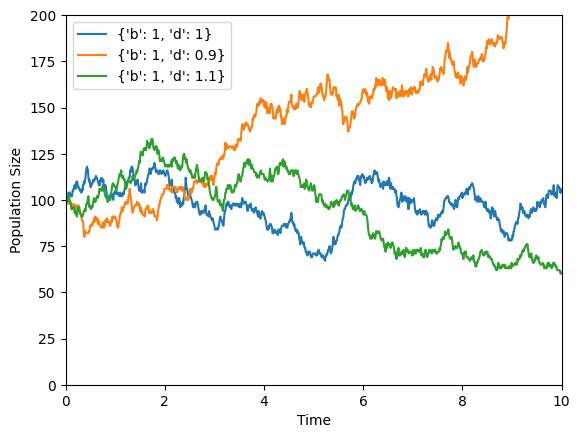

In [382]:
parameters = {"b": 1, "d": 1}
parameters2 = {"b": 1, "d": 0.9}
parameters3 = {"b": 1, "d": 1.1}

result = birth_death_process.sample_at_times(100, timepoints, parameters)
result2 = birth_death_process.sample_at_times(100, timepoints, parameters2)
result3 = birth_death_process.sample_at_times(100, timepoints, parameters3)
fig, ax = plt.subplots()
ax.set_xlim(0, 10)
ax.set_ylim(0, 200)
ax.set_xlabel("Time")
ax.set_ylabel("Population Size")
ax.plot(timepoints, result, label = f"{parameters}")
ax.plot(timepoints, result2, label = f"{parameters2}")
ax.plot(timepoints, result3, label = f"{parameters3}")

ax.legend()
plt.show()


## Stochastic CSAN Code

In [384]:

class State:
    def __init__(self, D, Es, Ts, EDTs, ETs):
        self.D = D
        self.Es = Es
        self.Ts = Ts
        self.EDTs = EDTs
        self.ETs = ETs

    def verify_coherence(self):
        if self.D < 0:
            return False
        for E in self.Es:
            if E < 0:
                return False
        for T in self.Ts:
            if T < 0:
                return False
        for EDT_by_E in self.EDTs:
            for EDT in EDT_by_E:
                if EDT < 0:
                    return False
        for ET_by_E in self.ETs:
            for ET in ET_by_E:
                if ET < 0:
                    return False
        return True

    def E(self):
        return sum(self.Es)
    
    def T(self):
        return sum(self.Ts)
    
    def EDT(self):
        return sum([sum(row) for row in self.EDTs])
    
    def ET(self):
        return sum([sum(row) for row in self.ETs])

    def total_D(self):
        total = self.D
        for i, E in enumerate(self.Es):
            total += i * E
        for i, T in enumerate(self.Ts):
            total += i * T
        for i, row in enumerate(self.EDTs):
            for j, EDT in enumerate(row):
                total += (i + j + 1) * EDT
        for i, row in enumerate(self.ETs):
            for j, ET in enumerate(row):
                total += (i + j) * ET
        return total

    def bound_D_per_E(self):
        total_bound_D = 0
        total_E = 0
        for i, E in enumerate(self.Es):
            total_bound_D += i * E
            total_E += E
        if total_bound_D == 0:
            return total_bound_D
        return total_bound_D / total_E
    
    def bound_D_per_T(self):
        total_bound_D = 0
        total_T = 0
        for i, T in enumerate(self.Ts):
            total_bound_D += i * T
            total_T += T
        if total_bound_D == 0:
            return total_bound_D
        return total_bound_D / total_T

    def export_to_list(self):
        l = [self.D]
        for e in self.Es:
            l.append(e)
        for t in self.Ts:
            l.append(t)
        for l1 in self.EDTs:
            for edt in l1:
                l.append(edt)
        for l1 in self.ETs:
            for et in l1:
                l.append(et)
        return l

    @staticmethod
    def import_from_list(l, e_receptors, t_receptors):
        Ds_end = 1
        D = l[0]
        Es_end = Ds_end + e_receptors + 1
        Es = l[Ds_end: Es_end]
        Ts_end = Es_end + t_receptors + 1
        Ts = l[Es_end:Ts_end]
        EDTs = []
        for i in range(e_receptors):
            start = Ts_end + i * t_receptors
            end = Ts_end + (i + 1) * t_receptors
            EDTs.append(l[start:end])
        ETs = []
        for i in range(e_receptors):
            start = Ts_end + i * t_receptors + t_receptors * e_receptors
            end = Ts_end + (i + 1) * t_receptors + t_receptors * e_receptors
            ETs.append(l[start:end])
        return State(D, Es, Ts, EDTs, ETs)
        

    def __repr__(self):
        return f"D: {self.D}. Es: {self.Es}. Ts: {self.Ts}. EDTs: {self.EDTs}. ETs: {self.ETs}"

    def __add__(self, other):
        return State(
            self.D + other.D, 
            [e1 + e2 for e1, e2 in zip(self.Es, other.Es)], 
            [t1 + t2 for t1, t2 in zip(self.Ts, other.Ts)],
            [[edt1 + edts for edt1, edt2 in zip(l1, l2)] for l1, l2 in zip(self.EDTs, other.EDTs)],
            [[et1 + ets for et1, et2 in zip(l1, l2)] for l1, l2 in zip(self.ETs, other.ETs)]
            )
    
    def __sub__(self, other):
        return State(
            self.D - other.D, 
            [e1 - e2 for e1, e2 in zip(self.Es, other.Es)], 
            [t1 - t2 for t1, t2 in zip(self.Ts, other.Ts)],
            [[edt1 - edts for edt1, edt2 in zip(l1, l2)] for l1, l2 in zip(self.EDTs, other.EDTs)],
            [[et1 - ets for et1, et2 in zip(l1, l2)] for l1, l2 in zip(self.ETs, other.ETs)],
            )

    def __mul__(self, other):
        return State(
            self.D * other, 
            [e1 * other for e1 in self.Es], 
            [t1 * other for t1 in self.Ts],
            [[edt1 * other for edt1 in l1] for l1 in self.EDTs],
            [[et1 * other for et1 in l1] for l1 in self.ETs]
            )

class CSANModel(Model):
    def __init__(self, e_receptors, t_receptors):
        self.e_receptors = e_receptors
        self.t_receptors = t_receptors

        events = []
        for bound_CSAN_count in range(e_receptors + 1):
            events.append(TCellDeath(bound_CSAN_count))
            events.append(TCellBinding(bound_CSAN_count, e_receptors))
            events.append(TCellInternalization(bound_CSAN_count, e_receptors))
        for bound_CSAN_count in range(t_receptors + 1):
            events.append(TumorBirth(bound_CSAN_count))
            events.append(TumorBinding(bound_CSAN_count, t_receptors))
            events.append(TumorInternalization(bound_CSAN_count, t_receptors))

        for TCell_bound_count in range(e_receptors + 1):
            for tumor_bound_count in range(t_receptors + 1):
                events.append(ED_TFormation(TCell_bound_count, tumor_bound_count, e_receptors, t_receptors))
                events.append(E_DTFormation(TCell_bound_count, tumor_bound_count, e_receptors, t_receptors))
                events.append(E_TFormation(TCell_bound_count, tumor_bound_count, e_receptors, t_receptors))
                
        for TCell_bound_count in range(e_receptors):
            for tumor_bound_count in range(t_receptors):
                events.append(TrimerDeath(TCell_bound_count, tumor_bound_count, e_receptors, t_receptors)) 
                events.append(DimerDeath(TCell_bound_count, tumor_bound_count, e_receptors, t_receptors))
        self.events = events
    
    
    def get_empty_state(self):
        D = 0
        Es = [0 for _ in range(self.e_receptors + 1)]
        Ts = [0 for _ in range(self.t_receptors + 1)]
        EDTs = [[0 for _ in range(self.t_receptors)] for __ in range(self.e_receptors)]
        ETs = [[0 for _ in range(self.t_receptors)] for __ in range(self.e_receptors)]
        
        return State(D, Es, Ts, EDTs, ETs)
    
class TCellDeath(Event):
    def __init__(self, bound_CSAN_count):
        self.bound_CSAN_count = bound_CSAN_count

    def get_rate(self, state, parameters):
        return state.Es[self.bound_CSAN_count] * parameters["d_E"]

    def implement(self, state):
        state.Es[self.bound_CSAN_count] = state.Es[self.bound_CSAN_count] - 1
        state.D = state.D + self.bound_CSAN_count
        return state

class TumorBirth(Event):
    def __init__(self, bound_CSAN_count):
        self.bound_CSAN_count = bound_CSAN_count
    
    def get_rate(self, state, parameters):
        return state.Ts[self.bound_CSAN_count] * parameters["b_T"]
        

    def implement(self, state):
        state.Ts[self.bound_CSAN_count] = state.Ts[self.bound_CSAN_count] - 1
        child_csans = np.random.binomial(self.bound_CSAN_count, 0.5)
        child_csans2 = self.bound_CSAN_count - child_csans
        state.Ts[child_csans] = state.Ts[child_csans] + 1
        state.Ts[child_csans2] = state.Ts[child_csans2] + 1
        return state
 
class TCellBinding(Event):
    def __init__(self, bound_CSAN_count, receptor_count):
        self.bound_CSAN_count = bound_CSAN_count
        self.receptor_count = receptor_count
        self.free_receptor_count = self.receptor_count - self.bound_CSAN_count
    
    def get_rate(self, state, parameters):
        return state.D * self.free_receptor_count * state.Es[self.bound_CSAN_count] * parameters["lambda_E"]
        
    
    def implement(self, state):
        state.D = state.D - 1
        state.Es[self.bound_CSAN_count] = state.Es[self.bound_CSAN_count] - 1
        state.Es[self.bound_CSAN_count + 1] = state.Es[self.bound_CSAN_count + 1] + 1
        return state

class TumorBinding(Event):
    def __init__(self, bound_CSAN_count, receptor_count):
        self.bound_CSAN_count = bound_CSAN_count
        self.receptor_count = receptor_count
        self.free_receptor_count = self.receptor_count - self.bound_CSAN_count
    
    def get_rate(self, state, parameters):
        return state.D * self.free_receptor_count * state.Ts[self.bound_CSAN_count] * parameters["lambda_T"]
         
    def implement(self, state):
        state.D = state.D - 1
        state.Ts[self.bound_CSAN_count] = state.Ts[self.bound_CSAN_count] - 1
        state.Ts[self.bound_CSAN_count + 1] = state.Ts[self.bound_CSAN_count + 1] + 1
        return state

class TCellInternalization(Event):
    def __init__(self, bound_CSAN_count, receptor_count):
        self.bound_CSAN_count = bound_CSAN_count
        self.receptor_count = receptor_count
        self.free_receptor_count = self.receptor_count - self.bound_CSAN_count
    
    def get_rate(self, state, parameters):
        return self.bound_CSAN_count * state.Es[self.bound_CSAN_count] * parameters["mu_E"]
        
    
    def implement(self, state):
        state.Es[self.bound_CSAN_count] = state.Es[self.bound_CSAN_count] - 1
        state.Es[self.bound_CSAN_count - 1] = state.Es[self.bound_CSAN_count - 1] + 1
        return state

class TumorInternalization(Event):
    def __init__(self, bound_CSAN_count, receptor_count):
        self.bound_CSAN_count = bound_CSAN_count
        self.receptor_count = receptor_count
        self.free_receptor_count = self.receptor_count - self.bound_CSAN_count
    
    def get_rate(self, state, parameters):
        return self.bound_CSAN_count * state.Ts[self.bound_CSAN_count] * parameters["mu_T"]
        
    
    def implement(self, state):
        state.Ts[self.bound_CSAN_count] = state.Ts[self.bound_CSAN_count] - 1
        state.Ts[self.bound_CSAN_count - 1] = state.Ts[self.bound_CSAN_count - 1] + 1
        return state

class ED_TFormation(Event):
    def __init__(self, TCell_bound_count, tumor_bound_count, TCell_receptors, tumor_receptors):
        self.TCell_bound_count = TCell_bound_count
        self.tumor_bound_count = tumor_bound_count
        self.TCell_receptors = TCell_receptors
        self.tumor_receptors = tumor_receptors

    def get_rate(self, state, model_parameters):
        p_e_t = model_parameters["p_E|T"]
        p_ed_t = model_parameters["p_ED|T"]
        p_e_dt = model_parameters["p_E|DT"]
        lambda_ET = model_parameters["lambda_ET"]
        m = model_parameters["M"]
        c_e_t = (self.TCell_receptors - self.TCell_bound_count) * (self.tumor_receptors - self.tumor_bound_count) * p_e_t / (self.TCell_receptors * self.tumor_receptors)
        c_e_dt = (self.TCell_receptors - self.TCell_bound_count) * self.tumor_bound_count * p_e_dt / (self.TCell_receptors * self.tumor_receptors)
        c_ed_t = self.TCell_bound_count * (self.tumor_receptors - self.tumor_bound_count) * p_ed_t / (self.TCell_receptors * self.tumor_receptors)

        c_f = 1 - c_e_t - c_e_dt - c_ed_t
        if c_f == 1:
            return 0

        return lambda_ET * (1 - c_f ** m) * state.Es[self.TCell_bound_count] * state.Ts[self.tumor_bound_count] * c_ed_t / (c_e_t + c_e_dt + c_ed_t)

    def implement(self, state):
        state.Es[self.TCell_bound_count] = state.Es[self.TCell_bound_count] - 1
        state.Ts[self.tumor_bound_count] = state.Ts[self.tumor_bound_count] - 1
        state.EDTs[self.TCell_bound_count - 1][self.tumor_bound_count] = state.EDTs[self.TCell_bound_count - 1][self.tumor_bound_count] + 1
        return state
    
class E_DTFormation(Event):
    def __init__(self, TCell_bound_count, tumor_bound_count, TCell_receptors, tumor_receptors):
        self.TCell_bound_count = TCell_bound_count
        self.tumor_bound_count = tumor_bound_count
        self.TCell_receptors = TCell_receptors
        self.tumor_receptors = tumor_receptors

    def get_rate(self, state, model_parameters):
        p_e_t = model_parameters["p_E|T"]
        p_ed_t = model_parameters["p_ED|T"]
        p_e_dt = model_parameters["p_E|DT"]
        lambda_ET = model_parameters["lambda_ET"]
        m = model_parameters["M"]
        c_e_t = (self.TCell_receptors - self.TCell_bound_count) * (self.tumor_receptors - self.tumor_bound_count) * p_e_t / (self.TCell_receptors * self.tumor_receptors)
        c_e_dt = (self.TCell_receptors - self.TCell_bound_count) * self.tumor_bound_count * p_e_dt / (self.TCell_receptors * self.tumor_receptors)
        c_ed_t = self.TCell_bound_count * (self.tumor_receptors - self.tumor_bound_count) * p_ed_t / (self.TCell_receptors * self.tumor_receptors)

        c_f = 1 - c_e_t - c_e_dt - c_ed_t

        
        if c_f == 1:
            return 0
        return lambda_ET * (1 - c_f ** m) * state.Es[self.TCell_bound_count] * state.Ts[self.tumor_bound_count] * c_e_dt / (c_e_t + c_e_dt + c_ed_t)

    def implement(self, state):
        state.Es[self.TCell_bound_count] = state.Es[self.TCell_bound_count] - 1
        state.Ts[self.tumor_bound_count] = state.Ts[self.tumor_bound_count] - 1
        state.EDTs[self.TCell_bound_count][self.tumor_bound_count - 1] = state.EDTs[self.TCell_bound_count][self.tumor_bound_count - 1] + 1
        return state
    
class E_TFormation(Event):
    def __init__(self, TCell_bound_count, tumor_bound_count, TCell_receptors, tumor_receptors):
        self.TCell_bound_count = TCell_bound_count
        self.tumor_bound_count = tumor_bound_count
        self.TCell_receptors = TCell_receptors
        self.tumor_receptors = tumor_receptors

    def get_rate(self, state, model_parameters):
        p_e_t = model_parameters["p_E|T"]
        p_ed_t = model_parameters["p_ED|T"]
        p_e_dt = model_parameters["p_E|DT"]
        lambda_ET = model_parameters["lambda_ET"]
        m = model_parameters["M"]
        c_e_t = (self.TCell_receptors - self.TCell_bound_count) * (self.tumor_receptors - self.tumor_bound_count) * p_e_t / (self.TCell_receptors * self.tumor_receptors)
        c_e_dt = (self.TCell_receptors - self.TCell_bound_count) * self.tumor_bound_count * p_e_dt / (self.TCell_receptors * self.tumor_receptors)
        c_ed_t = self.TCell_bound_count * (self.tumor_receptors - self.tumor_bound_count) * p_ed_t / (self.TCell_receptors * self.tumor_receptors)

        c_f = 1 - c_e_t - c_e_dt - c_ed_t

        
        if c_f == 1:
            return 0
        return lambda_ET * (1 - c_f ** m) * state.Es[self.TCell_bound_count] * state.Ts[self.tumor_bound_count] * c_e_t / (c_e_t + c_e_dt + c_ed_t)

    def implement(self, state):
        state.Es[self.TCell_bound_count] = state.Es[self.TCell_bound_count] - 1
        state.Ts[self.tumor_bound_count] = state.Ts[self.tumor_bound_count] - 1
        state.ETs[self.TCell_bound_count][self.tumor_bound_count] = state.ETs[self.TCell_bound_count][self.tumor_bound_count] + 1
        return state
    
class TrimerDeath(Event):
    def __init__(self, TCell_bound_count, tumor_bound_count, TCell_receptors, tumor_receptors):
        self.TCell_bound_count = TCell_bound_count
        self.tumor_bound_count = tumor_bound_count
        self.TCell_receptors = TCell_receptors
        self.tumor_receptors = tumor_receptors

    def get_rate(self, state, model_parameters):
        d_EDT = model_parameters["d_EDT"]
        return d_EDT * state.EDTs[self.TCell_bound_count][self.tumor_bound_count]
    
    def implement(self, state):
        state.EDTs[self.TCell_bound_count][self.tumor_bound_count] = state.EDTs[self.TCell_bound_count][self.tumor_bound_count] - 1
        state.D = state.D + self.tumor_bound_count
        state.Es[self.TCell_bound_count + 1] = state.Es[self.TCell_bound_count + 1] + 1 
        return state
    
class DimerDeath(Event):
    def __init__(self, TCell_bound_count, tumor_bound_count, TCell_receptors, tumor_receptors):
        self.TCell_bound_count = TCell_bound_count
        self.tumor_bound_count = tumor_bound_count
        self.TCell_receptors = TCell_receptors
        self.tumor_receptors = tumor_receptors
    
    def get_rate(self, state, model_parameters):
        d_ET = model_parameters["d_ET"]
        return d_ET * state.ETs[self.TCell_bound_count][self.tumor_bound_count]
    
    def implement(self, state):
        state.ETs[self.TCell_bound_count][self.tumor_bound_count] = state.ETs[self.TCell_bound_count][self.tumor_bound_count] - 1
        state.D = state.D + self.tumor_bound_count
        state.Es[self.TCell_bound_count] = state.Es[self.TCell_bound_count] + 1 
        return state


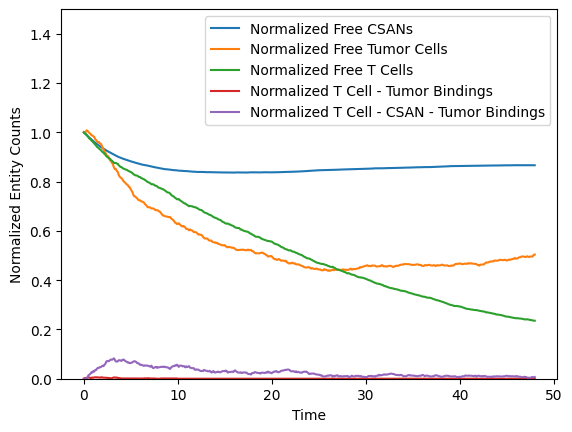

In [390]:
parameters = {
    "b_E": 0,
    "b_T": 0.03,
    "d_E": 0.03, 
    "d_T": 0, 
    "lambda_E": 0.000001, 
    "lambda_T": 0.000001, 
    "mu_E": 0.01,
    "mu_T": 0.01,
    "lambda_ET": 0.00003,
    "p_E|T": 0.02,
    "p_E|DT": 0.8,
    "p_ED|T": 0.8,
    "M": 10,
    "d_EDT": 1,
    "d_ET": 1,
}


duration = 48
timesteps = 480
times = [duration * i / timesteps for i in range(timesteps + 1)]
e_receptors = 10
t_receptors = 10
model = CSANModel(e_receptors, t_receptors)
state = model.get_empty_state()

# initial values
state.D = 128000

state.Es[0] = 3000
state.Ts[0] = 1000
 
result = model.sample_at_times(state, times, parameters)

fig, ax = plt.subplots()
initial_state = result[0]
d = [data.D / initial_state.D for data in result]
t = [sum(data.Ts) / sum(initial_state.Ts) for data in result]
e = [sum(data.Es) / sum(initial_state.Es) for data in result]
et = [sum([sum(row) for row in data.ETs]) /  sum(initial_state.Ts) for data in result]
edt = [sum([sum(row) for row in data.EDTs]) /  sum(initial_state.Ts) for data in result]

x = times

ax.plot(x, d, label="Normalized Free CSANs")
ax.plot(x, t, label="Normalized Free Tumor Cells")
ax.plot(x, e, label="Normalized Free T Cells")
ax.plot(x, et, label="Normalized T Cell - Tumor Bindings")
ax.plot(x, edt, label="Normalized T Cell - CSAN - Tumor Bindings")
#ax.plot(x, y_d_total, label = "Normalized CSANs (All)")
#ax.plot(x, y_bound_d_per_e, label = "Fraction of Free T Cell Receptors Bound to CSAN")
#ax.plot(x, y_bound_d_per_t, label = "Fraction of Free Tumor Receptors Bound to CSAN")
ax.set_ybound(0, 1.5)
ax.set_xlabel("Time")
ax.set_ylabel("Normalized Entity Counts")
plt.legend()
plt.show()


    


### Hook Effect

We want to investigate the possibility of a hook effect.

Simulating dose 16...
Simulating dose 62...
Simulating dose 250...
Simulating dose 1000...
Simulating dose 4000...
Simulating dose 16000...
Simulating dose 64000...
Simulating dose 256000...
Simulating dose 1024000...
Simulating dose 4096000...


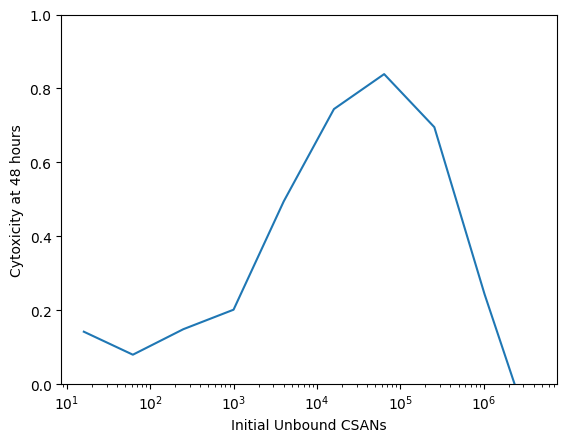

In [398]:
parameters = {
    "b_E": 0,
    "b_T": 0.03,
    "d_E": 0.03, 
    "d_T": 0, 
    "lambda_E": 0.000001, 
    "lambda_T": 0.000001, 
    "mu_E": 0.01,
    "mu_T": 0.01,
    "lambda_ET": 0.00003,
    "p_E|T": 0.02,
    "p_E|DT": 0.8,
    "p_ED|T": 0.8,
    "M": 10,
    "d_EDT": 1,
    "d_ET": 1,
}


duration = 48
timesteps = 480
times = [duration * i / timesteps for i in range(timesteps + 1)]
e_receptors = 10
t_receptors = 10
model = CSANModel(e_receptors, t_receptors)
state = model.get_empty_state()

# initial values
Ds = [16, 62, 250, 1000, 4000, 16000, 64000, 256000, 1024000, 4096000]

state.Es[0] = 3000
state.Ts[0] = 1000
results = []
for D in Ds:
    state.D = D
    print(f"Simulating dose {D}...")
    results.append(model.sample_at_times(state, times, parameters))

state.D = 0
control = model.sample_at_times(state, times, parameters)


control = sum(control[-1].Ts)

cytotoxicities = []
for result in results:
    cytotoxicities.append(1 - sum(result[-1].Ts) / control)

fig, ax = plt.subplots()
initial_state = result[0]

x = Ds

ax.plot(x, cytotoxicities)

ax.set_ybound(0, 1)
ax.set_xlabel("Initial Unbound CSANs")
ax.set_ylabel("Cytoxicity at 48 hours")
ax.set_xscale("log")
plt.show()


Simulating dose 16...
Simulating dose 62...
Simulating dose 250...
Simulating dose 1000...
Simulating dose 4000...
Simulating dose 16000...
Simulating dose 64000...
Simulating dose 256000...
Simulating dose 1024000...
Simulating dose 4096000...


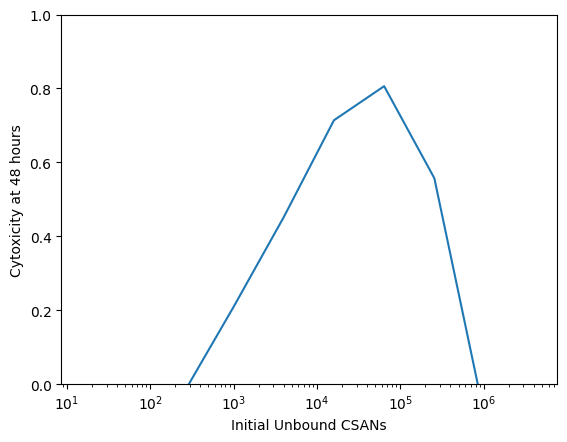

In [399]:
parameters = {
    "b_E": 0,
    "b_T": 0.03,
    "d_E": 0.03, 
    "d_T": 0, 
    "lambda_E": 0.000001, 
    "lambda_T": 0.000001, 
    "mu_E": 0,
    "mu_T": 0,
    "lambda_ET": 0.00003,
    "p_E|T": 0.02,
    "p_E|DT": 0.8,
    "p_ED|T": 0.8,
    "M": 10,
    "d_EDT": 1,
    "d_ET": 1,
}


duration = 48
timesteps = 480
times = [duration * i / timesteps for i in range(timesteps + 1)]
e_receptors = 10
t_receptors = 10
model = CSANModel(e_receptors, t_receptors)
state = model.get_empty_state()

# initial values
Ds = [16, 62, 250, 1000, 4000, 16000, 64000, 256000, 1024000, 4096000]

state.Es[0] = 3000
state.Ts[0] = 1000
results = []
for D in Ds:
    state.D = D
    print(f"Simulating dose {D}...")
    results.append(model.sample_at_times(state, times, parameters))

state.D = 0
control = model.sample_at_times(state, times, parameters)


control = sum(control[-1].Ts)

cytotoxicities = []
for result in results:
    cytotoxicities.append(1 - sum(result[-1].Ts) / control)

fig, ax = plt.subplots()
initial_state = result[0]

x = Ds

ax.plot(x, cytotoxicities)

ax.set_ybound(0, 1)
ax.set_xlabel("Initial Unbound CSANs")
ax.set_ylabel("Cytoxicity at 48 hours")
ax.set_xscale("log")
plt.show()


In [ ]:
parameters = {
    "b_E": 0,
    "b_T": 0.03,
    "d_E": 0.03, 
    "d_T": 0, 
    "lambda_E": 0.000001, 
    "lambda_T": 0.000001, 
    "mu_E": 0.5,
    "mu_T": 0.5,
    "lambda_ET": 0.00003,
    "p_E|T": 0.02,
    "p_E|DT": 0.8,
    "p_ED|T": 0.8,
    "M": 10,
    "d_EDT": 1,
    "d_ET": 1,
}


duration = 48
timesteps = 480
times = [duration * i / timesteps for i in range(timesteps + 1)]
e_receptors = 10
t_receptors = 10
model = CSANModel(e_receptors, t_receptors)
state = model.get_empty_state()

# initial values
Ds = [16, 62, 250, 1000, 4000, 16000, 64000, 256000, 1024000, 4096000]

state.Es[0] = 3000
state.Ts[0] = 1000
results = []
for D in Ds:
    state.D = D
    print(f"Simulating dose {D}...")
    results.append(model.sample_at_times(state, times, parameters))

state.D = 0
control = model.sample_at_times(state, times, parameters)


control = sum(control[-1].Ts)

cytotoxicities = []
for result in results:
    cytotoxicities.append(1 - sum(result[-1].Ts) / control)

fig, ax = plt.subplots()
initial_state = result[0]

x = Ds

ax.plot(x, cytotoxicities)

ax.set_ybound(0, 1)
ax.set_xlabel("Initial Unbound CSANs")
ax.set_ylabel("Cytoxicity at 48 hours")
ax.set_xscale("log")
plt.show()


Simulating dose 16...
Simulating dose 62...
Simulating dose 250...
Simulating dose 1000...
Simulating dose 4000...
Simulating dose 16000...
Simulating dose 64000...
Simulating dose 256000...
Simulating dose 1024000...
Simulating dose 4096000...
